## Group-level Results

In [1]:
import set_path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import signal
from scipy import linalg
from scipy import stats
from scipy.fftpack import fft, ifft
import scipy.io as sio
import os
import shutil
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import pickle
import copy
import random
import nrrd
from pathlib import Path
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.core.structure_tree import StructureTree
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

from utils import *
from settings import settings
from hyperparams import *

In [2]:
cache = EcephysProjectCache.from_warehouse(manifest=settings.observatory.manifest_path)
sessions = cache.get_session_table()
channels = cache.get_channels()
units = cache.get_units()

session_fc_ids = sessions[sessions['session_type']=='functional_connectivity'].index.values
session_used = np.setdiff1d(session_fc_ids,settings.observatory.sess_removed)

In [3]:
def extract_seg(sig,centers,hwinsz):
    """ extract segments from signals """
    
    if sig.ndim == 2:
        seg = np.zeros((hwinsz*2+1,sig.shape[1],centers.size))
        for cnt in range(centers.size):
            seg[:,:,cnt] = sig[centers[cnt]-hwinsz:centers[cnt]+hwinsz+1,:]
        return seg
    elif sig.ndim == 1:     
        seg = np.zeros((hwinsz*2+1,centers.size))
        for cnt in range(centers.size):
            seg[:,cnt] = sig[centers[cnt]-hwinsz:centers[cnt]+hwinsz+1]
        return seg
    else:
        sys.exit('ndim of sig musts be either 1 or 2')

In [4]:
def phaseScrambleTS(ts):
    """Returns a TS: original TS power is preserved; TS phase is shuffled."""
    fs = fft(ts)
    pow_fs = np.abs(fs) ** 2.
    phase_fs = np.angle(fs)
    phase_fsr = phase_fs.copy()
    phase_fsr_lh = phase_fsr[1:np.ceil(len(phase_fsr)/2).astype(int)]
    np.random.shuffle(phase_fsr_lh)
    phase_fsr_rh = -phase_fsr_lh[::-1]
    phase_fsr[1:np.ceil(len(phase_fsr)/2).astype(int)] = phase_fsr_lh.copy()
    phase_fsr[int(len(phase_fsr)/2+1):] = phase_fsr_rh.copy()
    fsrp = np.sqrt(pow_fs) * (np.cos(phase_fsr) + 1j * np.sin(phase_fsr))
    tsr = np.real(ifft(fsrp))
    return tsr

In [5]:
def fano_old(sig,winsize):
    if np.floor(winsize/2) == winsize/2:
        sys.exit('Put an odd number for window size')
    hsz = int(np.floor(winsize/2))
    ff = np.zeros(sig.shape)
    for ind in range(hsz,sig.size-hsz):
        tmp = sig[ind-hsz:ind+hsz].values
        ff[ind] = np.var(tmp)/np.mean(tmp)
    ff[0:hsz-1] = ff[hsz]
    ff[sig.size-hsz+1:-1]=ff[sig.size-hsz]
    return ff    

In [6]:
def fano(sig,winsize):
    if np.floor(winsize/2) == winsize/2:
        sys.exit('Put an odd number for window size')
    hsz = int(np.floor(winsize/2))
    ff = np.zeros(sig.shape)
    for ind in range(hsz,sig.size-hsz):
        tmp = sig[ind-hsz:ind+hsz].values
        ff[ind] = np.var(tmp)/np.mean(tmp)
    ff[0:hsz] = ff[hsz]
    ff[sig.size-hsz:]=ff[sig.size-hsz-1]
    return ff    

In [7]:
unitall_df = list()
unitlocall = pd.DataFrame()

samskall = list()
ctlmskall = list()
segmeanall = list()
sindall = list()

# spiking activity
dc = list()
dc_c = list()
segmsk = list()

# pupil
psegall = list()
pmall = list()
pmall_ctrl = list()

# running speed
rsegall = list()
rmall = list()
rmall_ctrl = list()

# hippocampus ripples
rpsegall = list()
rpmall = list()
rpmall_ctrl = list()

# delta wave
dpwall = list()
qtmskdpwall = list()
dpsegall = list()
dpmall = list()
dpmall_ctrl = list()

# negative-delay neurons
pthr_corr = 0.001
pthr_mean = 0.001
pthr_corr_ctrl = 0.05

negsegall = list()
negmall = list()
negmall_ctrl = list()

# positive-delay neurons
possegall = list()
posmall = list()
posmall_ctrl = list()

# cross-correlation
cctime = np.arange(0,101)*.2 - 10
cctmsk = (cctime>-12) & (cctime<12)
gratio = list()
gratio2 = list()
gratio_c = list()
pktime = list()
pktime_c = list()
pktime_c2 = list()
ff_all = list()
ffold_all = list()
qtmsk_all = list()

# eye tracking
ppdist2 = np.zeros((len(session_used),2))
ppsize2 = np.zeros((len(session_used),2))

ppdist3 = np.zeros((len(session_used),2))
ppsize3 = np.zeros((len(session_used),2))
eyeheight3 = np.zeros((len(session_used),2))

# PCA
topn = 20
svarp_all = np.zeros((topn, len(session_used)))
svarp_all_pm = np.zeros((topn, len(session_used)))

# running/stationary transition
rseg_sall = list()
rseg_eall = list()
nseg_sall = list()
nseg_eall = list()
pseg_sall = list()
pseg_eall = list()

# stimulus response
rspp_thr=0.001
corr_res = pd.DataFrame()
dgrdf = pd.DataFrame()
dgrtc_all = list()

for i, sid in enumerate(session_used):
    print('processing {:d}'.format(sid))
    
    """ load data """
    sessDir = settings.projectData.dir.sessions / 'session_{:d}'.format(sid)

    varName = 'sessData'
    fName = getattr(settings.projectData.files.sessions, varName)
    fPath = sessDir / fName
    with open(fPath, 'rb') as handle:
        sessData = pickle.load(handle)

    varName = 'rsData1'
    fName = getattr(settings.projectData.files.sessions, varName)
    fPath = sessDir / fName
    with open(fPath, 'rb') as handle:
        rsData = pickle.load(handle)
    
    varName = 'lfpData'
    fName = getattr(settings.projectData.files.sessions, varName)
    fPath = sessDir / fName
    with open(fPath, 'rb') as handle:
        lfpData = pickle.load(handle)
    
    varName = 'flData'
    fName = getattr(settings.projectData.files.sessions, varName)
    fPath = sessDir / fName
    with open(fPath, 'rb') as handle:
        flData = pickle.load(handle)

    varName = 'dgrData'
    fName = getattr(settings.projectData.files.sessions, varName)
    fPath = sessDir / fName
    with open(fPath, 'rb') as handle:
        dgrData = pickle.load(handle)
        
    """ spiking activity """
    dprfsn_c = rsData.dprfsn.copy()
    [np.random.shuffle(item) for item in dprfsn_c.T]
    dlycor_c = np.corrcoef(dprfsn_c.T,rsData.U[:,0].T)[:-1,-1]
    
    segrunmsk = rsData.qtmsk[rsData.glspksind]
    
    dc.append(rsData.dlycor)
    dc_c.append(dlycor_c)
    segmsk.append(segrunmsk)
        
    """ positive and negative delay neurons """
    
    corrthr = np.tanh(stats.norm.ppf(1 - pthr_corr/2) / np.sqrt(sum(rsData.glsnind)  - 3))
    corrthr_ctrl = np.tanh(stats.norm.ppf(1 - pthr_corr_ctrl/2) / np.sqrt(sum(rsData.glsnind) - 3))

    dprfsn_sgnf = rsData.dprfsn[:,rsData.dlycor>corrthr]
    delay_tscore, delay_signp = stats.ttest_1samp(dprfsn_sgnf.T, 0)
    delay_signp = delay_signp * np.sign(delay_tscore)

    negumsk = (delay_signp > -pthr_mean) & (delay_signp < 0)
    posumsk = (delay_signp < pthr_mean) & (delay_signp > 0)
    negct2 = rsData.spikect2[:,negumsk].mean(axis=1)
    posct2 = rsData.spikect2[:,posumsk].mean(axis=1)

    posonsetind,_,_ = stats.binned_statistic(np.arange(posct2.size-1), np.diff(posct2), statistic=np.argmax, bins=rsData.npks)
    posonsetind = posonsetind.astype(int) + rsData.npks[:-1]
    
    twin = 20
    time_segct = (np.arange(2*twin) - twin) * rsData.tstep
    spkctseg = extract_seg(rsData.spikect2, posonsetind, twin)
    segmean = spkctseg[:,:,rsData.dlycor>corrthr].mean(axis=2)
    segpks = np.argmax(segmean[:31,:],axis=0)
    segtime = time_segct[:31]

    lm = stats.linregress(rsData.U[:,0], segtime[segpks])
    delay_sec = rsData.U[:,0] * lm.slope
    
    unitdf = rsData.unitdf

    unitdf['delay_tscore'] = delay_tscore
    unitdf['delay_sec'] = delay_sec
    unitdf['delay_signp'] = delay_signp
    
    """ resting-state neuron activity vs running """
    running_spkdiff= rsData.spikect2[rsData.qtmsk==0,:].mean(axis=0) - rsData.spikect2[rsData.qtmsk==1,:].mean(axis=0)

    running_speed_spk, _, _ = stats.binned_statistic(rsData.running_time, 
                                                     abs(rsData.running_speed), 
                                                     statistic=np.nanmean, bins=rsData.tbins)
    m = ~np.isnan(running_speed_spk)
    rscorr = np.corrcoef(rsData.spikect2[m,:].T, running_speed_spk[m])[:-1,-1]
    m = m & (rsData.qtmsk == 1)
    rscorr_qt = np.corrcoef(rsData.spikect2[m,:].T, running_speed_spk[m])[:-1,-1]

    running_tscore, running_signp = stats.ttest_ind(rsData.spikect2[rsData.qtmsk == 0,:], 
                                                    rsData.spikect2[rsData.qtmsk == 1,:])
    running_signp = running_signp * np.sign(running_tscore)

    unitdf['running_spkdiff'] = running_spkdiff
    unitdf['rscorr'] = rscorr
    unitdf['rscorr_qt'] = rscorr_qt
    unitdf['running_tscore'] = running_tscore
    unitdf['running_signp'] = running_signp
    
    """ resting-state neuron activity vs pupil size """
    pupil_size_spk, _, _ = stats.binned_statistic(rsData.pupil_time, 
                                              rsData.pupil_size, 
                                              statistic=np.nanmean, bins=rsData.tbins)
    m = ~np.isnan(pupil_size_spk)
    pscorr = np.corrcoef(rsData.spikect2[m,:].T, pupil_size_spk[m])[:-1,-1]
    m = m & (rsData.qtmsk == 1)
    pscorr_qt = np.corrcoef(rsData.spikect2[m,:].T, pupil_size_spk[m])[:-1,-1]

    unitdf['pscorr'] = pscorr
    unitdf['pscorr_qt'] = pscorr_qt
    
    """ measurements around positive neuron onset """
    glspksind_dp = np.abs(np.subtract.outer(lfpData.rs_lfpVISdp.time.values, 
                                            rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
    glspksind_pupil = np.abs(np.subtract.outer(rsData.pupil_time, 
                                               rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
    glspksind_run = np.abs(np.subtract.outer(rsData.running_time, 
                                             rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
    glspksind_rm = np.abs(np.subtract.outer(lfpData.CA1time, 
                                            rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
    
    segqtmsk = stats.binned_statistic(np.arange(rsData.qtmsk.size),
                                      rsData.qtmsk, statistic='mean', bins=rsData.npks).statistic
    
    samsk = (rsData.dlycor > corrthr) & (segqtmsk == 1) # segments includes cascade evenets
    ctlmsk = (abs(rsData.dlycor) < pthr_corr_ctrl) & (segqtmsk == 1) # segements for control 
    
    # ripple event around positive neuron onset
    ripplemsk = lfpData.ripplemsk[:,lfpData.chn]
    ripplemsk[ripplemsk.nonzero()] = 1
    rpseg = extract_seg(ripplemsk, glspksind_rm, 5000)
    rpmean = rpseg[:,samsk==1].mean(axis=1)
    rpmean_ctrl = rpseg[:,ctlmsk==1].mean(axis=1)
    
    # delta wave around positive neuron onset
    dpw = lfpData.rs_lfpVISdp.mean(axis=1)
    qtmskdpw = np.interp(dpw.time, rsData.running_time, rsData.qtmskorg)
    qtmskdpw = np.round(qtmskdpw)
    dpwn = dpw / dpw.mean()
    dpseg = extract_seg(dpwn, glspksind_dp, 500)
    dpmean = dpseg[:,samsk].mean(axis=1)
    dpmean_ctrl = dpseg[:,ctlmsk].mean(axis=1)
    
    # pupil size around positive neuron onset
    qtmskpp = np.interp(rsData.pupil_time, rsData.running_time, rsData.qtmskorg)
    qtmskpp = np.round(qtmskpp)
    rs_pupil_sizen = rsData.pupil_size / np.nanmean(rsData.pupil_size)
    pupilseg = extract_seg(rs_pupil_sizen, glspksind_pupil, 120)
    pmean = np.nanmean(pupilseg[:,samsk],axis=1)
    pmean_ctrl = np.nanmean(pupilseg[:,ctlmsk],axis=1)
    
    # running speed around positive neuron onset
    runseg = extract_seg(rsData.running_speed, glspksind_run, 160)
    rmean = np.nanmean(runseg[:,samsk],axis=1)
    rmean_ctrl = np.nanmean(runseg[:,ctlmsk],axis=1)
    if sid ==821695405:
        tmp = runseg[:,samsk].copy()
        tmp = tmp[:,tmp.mean(axis=0)<0.2]
        rmean = np.nanmean(tmp,axis=1)
    
    # positive-delay neuron activity around positive neuron onset
    posseg = extract_seg(posct2, posonsetind, 20)
    posmean = np.nanmean(posseg[:,samsk],axis=1)
    posmean_ctrl = np.nanmean(posseg[:,ctlmsk],axis=1)
    
    # negative-delay neuron activity around positive neuron onset
    negseg = extract_seg(negct2, posonsetind, 20)
    negmean = np.nanmean(negseg[:,samsk],axis=1)
    negmean_ctrl = np.nanmean(negseg[:,ctlmsk],axis=1)
    
    unitall_df.append(unitdf)
    
    samskall.append(samsk)
    ctlmskall.append(ctlmsk)
    segmeanall.append(segmean)
    sindall.append(rsData.sind)

    psegall.append(pupilseg)
    pmall.append(pmean)
    pmall_ctrl.append(pmean_ctrl)
    
    rsegall.append(runseg)
    rmall.append(rmean)
    rmall_ctrl.append(rmean_ctrl)
    
    rpsegall.append(rpseg)
    rpmall.append(rpmean)
    rpmall_ctrl.append(rpmean_ctrl)
    
    dpwall.append(dpwn)
    dpsegall.append(dpseg)
    dpmall.append(dpmean)
    dpmall_ctrl.append(dpmean_ctrl)
    qtmskdpwall.append(qtmskdpw)
    
    negsegall.append(negseg)
    negmall.append(negmean)
    negmall_ctrl.append(negmean_ctrl)
    
    possegall.append(posseg)
    posmall.append(posmean)
    posmall_ctrl.append(posmean_ctrl)
    
    """ fano factor """
    gls0 = rsData.spikect.sum(axis=1)
    ff = fano(gls0, 11)
    ffold = fano_old(rsData.gls, 11)
    
    """ cross-correlation """
    # original signal
    spikect2f_qt = rsData.spikect2f[rsData.qtmsk==1,:].copy()
    qtlen = spikect2f_qt[250:-250,:].shape[0]

    cc_gls = [];# cc function of real signal
    sig = spikect2f_qt[250:-250,:].copy()
    sig = signal.detrend(sig,axis=0)
    for ind in range(0,sig.shape[1]):
        tmp = sig[:,ind]
        gls = np.concatenate([sig[:,0:ind], sig[:,ind+1:]], axis=1).mean(axis=1)
        tmp2 = np.correlate((tmp-tmp.mean())/tmp.std()/len(tmp),(gls-gls.mean())/gls.std(),'full')
        cc_gls.append(tmp2[qtlen-50:qtlen+51])
    cc_gls = np.array(cc_gls)

    spikect2f_qtps = rsData.spikect2f[rsData.qtmsk==1,:].copy()
    for cnt in range(0,spikect2f_qtps.shape[1]):
        spikect2f_qtps[:,cnt] = phaseScrambleTS(spikect2f_qtps[:,cnt])

    cc_gls_c2 = []; # cc functional of shufffled signal with gs being the mean of phase shuffled signals
    sig = spikect2f_qtps[250:-250,:].copy()
    sig = signal.detrend(sig,axis=0)

    for ind in range(0,sig.shape[1]):
        tmp = sig[:,ind]
        glssig2 = np.concatenate([sig[:,0:ind], sig[:,ind+1:]], axis=1).mean(axis=1)
        tmp2 = np.correlate((tmp-tmp.mean())/tmp.std()/len(tmp),(glssig2-glssig2.mean())/glssig2.std(),'full')
        cc_gls_c2.append(tmp2[qtlen-50:qtlen+51])
    cc_gls_c2 = np.array(cc_gls_c2)

    ccsind = np.argsort(abs(cc_gls[:,cctmsk]).argmax(axis=1))
    pkt = cctime[abs(cc_gls[:,:]).argmax(axis=1)]
    ccsind_c2 = np.argsort(abs(cc_gls_c2[:,cctmsk]).argmax(axis=1))
    pkt_c2 = cctime[abs(cc_gls_c2[:,:]).argmax(axis=1)]
    
    # max correlation
    thr2=np.percentile(abs(cc_gls_c2)[:,cctmsk].max(axis=1),95)
    
    # ratio with significant correlation
    glscc_ratio2 = (abs(cc_gls)[:,cctmsk].max(axis=1)>thr2).sum() / sessData.unitid.size
    glscc_ratio_c = (abs(cc_gls_c2)[:,cctmsk].max(axis=1)>thr2).sum() / sessData.unitid.size
    
    gratio2.append(glscc_ratio2)
    gratio_c.append(glscc_ratio_c)
    pktime.append(pkt)
    pktime_c2.append(pkt_c2)
    ff_all.append(ff)
    ffold_all.append(ffold)
    qtmsk_all.append(rsData.qtmsk)
    
    tmp = sessData.unitloc.to_frame()
    tmp['ccsig'] = abs(cc_gls)[:,cctmsk].max(axis=1)>thr2
    unitlocall = unitlocall.append(tmp)
    
    """ eye tracking """
    rs_pupil_sizen = rsData.pupil_size / np.nanmean(rsData.pupil_size)
    qtmskpp = np.interp(rsData.pupil_time, rsData.running_time, rsData.qtmskorg).astype(int)
    
    pp_x = rsData.pupil_data['pupil_center_x'].values
    pp_y = rsData.pupil_data['pupil_center_y'].values
    dpp_x = np.diff(pp_x)
    dpp_y = np.diff(pp_y)
    dpp_dist = (dpp_x**2 + dpp_y**2)**0.5
    
    qtmskpp2= qtmskpp[1:]
    
    eyeh = rsData.pupil_data['eye_height'].values
    eyehn = eyeh/np.nanmean(eyeh)
    
    eyew = rsData.pupil_data['eye_width'].values
    eyewn = eyew/np.nanmean(eyew)
    
    dpp_distn = dpp_dist / np.nanmean(dpp_dist)
    
    ppdist2[i,0] = np.nanmean(dpp_dist[qtmskpp2==0])
    ppdist2[i,1] =  np.nanmean(dpp_dist[qtmskpp2==1])
    ppsize2[i,0] = np.nanmean(rsData.pupil_size[qtmskpp==0])
    ppsize2[i,1] = np.nanmean(rsData.pupil_size[qtmskpp==1])
    ppdist3[i,0] = np.nanmean(dpp_distn[qtmskpp2==0])
    ppdist3[i,1] =  np.nanmean(dpp_distn[qtmskpp2==1])
    ppsize3[i,0] = np.nanmean(rs_pupil_sizen[qtmskpp==0])
    ppsize3[i,1] = np.nanmean(rs_pupil_sizen[qtmskpp==1])
    eyeheight3[i,0] = np.nanmean(eyehn[qtmskpp==0])
    eyeheight3[i,1] = np.nanmean(eyehn[qtmskpp==1])
    
    """ variance percentage explianed by principal components  """ 
    _, s, _ = linalg.svd(rsData.dprfsn)
    svarp = (s * s) / (s * s).sum()
    
    dprfsn_pm = np.array([np.random.permutation(item) for item in rsData.dprfsn.T]).T
    _, s_pm, _ = linalg.svd(dprfsn_pm)
    svarp_pm = (s_pm * s_pm) / (s_pm * s_pm).sum()
    
    svarp_all[:,i] = svarp[:topn]
    svarp_all_pm[:,i] = svarp_pm[:topn]
    
    """ stimulus response """
    corrthr = np.tanh(stats.norm.ppf(1 - pthr_corr/2) / np.sqrt(sum(rsData.glsnind)  - 3))

    dprfsn_sgnf = rsData.dprfsn[:,rsData.dlycor>corrthr]
    delay_tscore, delay_signp = stats.ttest_1samp(dprfsn_sgnf.T, 0)
    delay_signp = delay_signp * np.sign(delay_tscore)

    twin = 15
    time_segct = (np.arange(2*twin) - twin) * rsData.tstep
    spkctseg = extract_seg(rsData.spikect2, rsData.glspksind, twin)
    segmean = spkctseg[:,:,rsData.dlycor>corrthr].mean(axis=2)
    segpks = np.argmax(segmean, axis=0)
    segtime = (np.arange(segmean.shape[0]) - int(segmean.shape[0]/2)) * rsData.tstep

    lm = stats.linregress(rsData.U[:,0],segtime[segpks])
    delay_sec = rsData.U[:,0] * lm.slope

    time_dgr = dgrData.tbins[:-1] + dgrData.tstep / 2
    
    ctrlmsk = (time_dgr<0)&(time_dgr>-0.8)
    presmsk = (time_dgr<0)&(time_dgr>-0.2)
    stimmsk = (time_dgr>0)
    stimmsk2 = (time_dgr>0)&(time_dgr<0.4)
    stimmsk3 = (time_dgr>0.4)&(time_dgr<10)
    
    for contrast in dgrData.stimTable['contrast'].unique():
        for orientation in dgrData.stimTable['orientation'].unique():

            submsk = (dgrData.stimTable['orientation']==orientation) & (dgrData.stimTable['contrast']==contrast)
            dgrstim2 = dgrData.stimTable[submsk].copy()
            spikect_dgr_seg = dgrData.spikect[submsk,:,:].copy()

            spikect_dgr_stim = spikect_dgr_seg[:,stimmsk,:].mean(axis=1) 
            spikect_dgr_stim2 = spikect_dgr_seg[:,stimmsk2,:].mean(axis=1) 
            spikect_dgr_stim3 = spikect_dgr_seg[:,stimmsk3,:].mean(axis=1) 
            spikect_dgr_ctrl = spikect_dgr_seg[:,ctrlmsk,:].mean(axis=1)
            spikect_dgr_rsp = spikect_dgr_stim - spikect_dgr_ctrl

            dgrrspt,dgrrspp = stats.ttest_1samp(spikect_dgr_rsp, 0)
            dgrsind = np.argsort(dgrrspt)

            negumsk = (delay_signp<0) & (delay_signp>-pthr_mean) & (dgrrspp>0.05)
            posumsk = (delay_signp>0) & (delay_signp<pthr_mean) & (dgrrspp>0.05)
            dgrumsk = (dgrrspp<rspp_thr) & (abs(delay_signp)>0.05) & (dgrrspt>0)

            tmp1 = spikect_dgr_seg[:,:,negumsk].mean(axis=2)
            tmp2 = spikect_dgr_seg[:,:,posumsk].mean(axis=2)
            tmp1 = tmp1[:,presmsk]
            tmp2 = tmp2[:,presmsk]

            dgr_bldiff = tmp1.mean(axis=1) - tmp2.mean(axis=1)

            dgr_stim2 = spikect_dgr_stim2[:,dgrumsk].mean(axis=1)
            dgr_stim3 = spikect_dgr_stim3[:,dgrumsk].mean(axis=1)
            dgr_ctrl = spikect_dgr_ctrl[:,dgrumsk].mean(axis=1)
            dgr_rsp2 = dgr_stim2 - dgr_ctrl; 
            dgr_rsp3 = dgr_stim3 - dgr_ctrl; 

            dgr_stim2n = dgr_stim2 / dgr_ctrl.mean()
            dgr_stim3n = dgr_stim3 / dgr_ctrl.mean()
            dgr_ctrln = dgr_ctrl / dgr_ctrl.mean()
            dgr_rsp2n = dgr_stim2n - dgr_ctrln; 
            dgr_rsp3n = dgr_stim3n - dgr_ctrln; 

            dgrstim2['dgr_stim2'] = dgr_stim2
            dgrstim2['dgr_stim3'] = dgr_stim3
            dgrstim2['dgr_ctrl'] = dgr_ctrl
            dgrstim2['dgr_rsp2'] = dgr_rsp2
            dgrstim2['dgr_rsp3'] = dgr_rsp3

            dgrstim2['dgr_stim2n'] = dgr_stim2n
            dgrstim2['dgr_stim3n'] = dgr_stim3n
            dgrstim2['dgr_ctrln'] = dgr_ctrln
            dgrstim2['dgr_rsp2n'] = dgr_rsp2n
            dgrstim2['dgr_rsp3n'] = dgr_rsp3n

            dgrstim2['dgr_bldiff'] = dgr_bldiff
            dgrstim2['session_id'] = sid

            tmp = dgrstim2.iloc[:,-12:-1].corr().reset_index().iloc[:-1,[0, -1]]
            tmp['session_id'] = sid
            tmp['contrast'] = contrast
            tmp['orientation'] = orientation
            corr_res = corr_res.append(tmp)

            dgr_topr = spikect_dgr_seg[:,:,dgrumsk].mean(axis=2)
            dgr_topr_blcg = (dgr_bldiff>np.percentile(dgr_bldiff,33.33333)).astype(int) + \
                            (dgr_bldiff>np.percentile(dgr_bldiff,66.66667)).astype(int)

            dgrtc_all.append(dgr_topr.values)
            dgrstim2['dgr_topr_blcg'] = dgr_topr_blcg

            dgrdf = dgrdf.append(dgrstim2)
    
    """ Running / Stationary Transition """
    d_qtmskorg = np.diff(rsData.qtmskorg)
    rstart = np.where(d_qtmskorg==-1)[0]
    rstart = rstart[(rstart>1600)&(rstart<d_qtmskorg.size-1600)]
    tmp = extract_seg(d_qtmskorg,rstart,1600)
    rstart = rstart[(tmp.sum(axis=0)==-1)]

    rend = np.where(d_qtmskorg==1)[0]
    rend = rend[(rend>1600)&(rend<d_qtmskorg.size-1600)]
    tmp = extract_seg(d_qtmskorg,rend,1600)
    rend = rend[(tmp.sum(axis=0)==1)]
    
    if rstart.size > 0:
        runseg_start = extract_seg(rsData.running_speed,rstart,1600)
        rstartind_spk = np.abs(np.subtract.outer(rsData.spikect2.time_relative_to_stimulus_onset.values, 
                                                 rsData.running_time[rstart])).argmin(0)
        negseg_start = extract_seg(negct2,rstartind_spk,200)
        posseg_start = extract_seg(posct2,rstartind_spk,200)
        
        rseg_sall.append(runseg_start)
        nseg_sall.append(negseg_start)
        pseg_sall.append(posseg_start)

    if rend.size > 0:   
        runseg_end = extract_seg(rsData.running_speed,rend,1600)
        rendind_spk = np.abs(np.subtract.outer(rsData.spikect2.time_relative_to_stimulus_onset.values, 
                                               rsData.running_time[rend])).argmin(0)
        negseg_end = extract_seg(negct2,rendind_spk,200)
        posseg_end = extract_seg(posct2,rendind_spk,200)

        rseg_eall.append(runseg_end)
        nseg_eall.append(negseg_end)
        pseg_eall.append(posseg_end)
    

processing 766640955
processing 771160300
processing 771990200
processing 774875821
processing 778998620
processing 779839471


/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


processing 781842082
processing 793224716


/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


processing 794812542


/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


processing 816200189


/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


processing 819186360
processing 821695405


/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])
/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
<ipython-input-7-f81748146fb6>:437: RuntimeWarning: invalid value encountered in greater
  negumsk = (delay_signp<0) & (delay_signp>-pthr_mean) & (dgrrspp>0.05)
<ipython-input-7-f81748146fb6>:438: RuntimeWarning: invalid value encountered in greater
  posumsk = (delay_signp>0) & (delay_signp<pthr_mean) & (dgrrspp>0.05)
<ipython-input-7-f81748146fb6>:439: RuntimeWarning: invalid value encountered in less
  dgrumsk = (dgrrspp<rspp_thr) & (abs(delay_signp)>0.05) & (dgrrspt>0)
<ipython-input-7-f81748146fb6>:439: RuntimeWarning: invalid value encountered in greater
  dgrumsk = (dgrrspp<rspp_thr) & (abs(delay_s

processing 829720705


/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:631: RuntimeWarning: Mean of empty slice
  result[vv, i] = statistic(values[vv, binnumbers == i])


processing 847657808


In [8]:
unitall_df = pd.concat(unitall_df)

dc = np.concatenate(dc)
dc_c = np.concatenate(dc_c)
segmsk = np.concatenate(segmsk)

psegall = np.concatenate(psegall, axis=1)
pmall = np.concatenate([item.reshape(-1,1) for item in pmall], axis=1)
pmall_ctrl = np.concatenate([item.reshape(-1,1) for item in pmall_ctrl], axis=1)

rsegall = np.concatenate(rsegall, axis=1)
rmall = np.concatenate([item.reshape(-1,1) for item in rmall], axis=1)
rmall_ctrl = np.concatenate([item.reshape(-1,1) for item in rmall_ctrl], axis=1)

rpsegall = np.concatenate(rpsegall, axis=1)
rpmall = np.concatenate([item.reshape(-1,1) for item in rpmall], axis=1)
rpmall_ctrl = np.concatenate([item.reshape(-1,1) for item in rpmall_ctrl], axis=1)

dpsegall = np.concatenate(dpsegall, axis=1)
dpmall = np.concatenate([item.reshape(-1,1) for item in dpmall], axis=1)
dpmall_ctrl = np.concatenate([item.reshape(-1,1) for item in dpmall_ctrl], axis=1)

negsegall = np.concatenate(negsegall, axis=1)
negmall = np.concatenate([item.reshape(-1,1) for item in negmall], axis=1)
negmall_ctrl = np.concatenate([item.reshape(-1,1) for item in negmall_ctrl], axis=1)

possegall = np.concatenate(possegall, axis=1)
posmall = np.concatenate([item.reshape(-1,1) for item in posmall], axis=1)
posmall_ctrl = np.concatenate([item.reshape(-1,1) for item in posmall_ctrl], axis=1)

gratio2 = np.array(gratio2)
gratio_c = np.array(gratio_c)
pktime = np.concatenate(pktime)
pktime_c2 = np.concatenate(pktime_c2)
ff_all = np.concatenate(ff_all)
ffold_all = np.concatenate(ffold_all)
qtmsk_all = np.concatenate(qtmsk_all)

dgrtc_all = np.concatenate(dgrtc_all, axis=0).T

rseg_sall = np.concatenate(rseg_sall, axis=1)
rseg_eall = np.concatenate(rseg_eall, axis=1)
nseg_sall = np.concatenate(nseg_sall, axis=1) * 100
nseg_eall = np.concatenate(nseg_eall, axis=1) * 100
pseg_sall = np.concatenate(pseg_sall, axis=1) * 100
pseg_eall = np.concatenate(pseg_eall, axis=1) * 100

In [9]:
pthr_corr = 0.01
unitall_df = unitall_df.rename(columns={'loc':'location'})
unitall_df = unitall_df.drop(index = unitall_df[unitall_df['lrc']<0].index)
unitall_df['ecephys_probe_id'] = units.loc[unitall_df.index, 'ecephys_probe_id']
unitall_df['ecephys_session_id'] = units.loc[unitall_df.index, 'ecephys_session_id']
unitall_df['delay_groups'] = (abs(unitall_df['delay_signp']) < pthr_corr) * np.sign(unitall_df['delay_signp']).astype(int)

In [10]:
mcc = MouseConnectivityCache(resolution = 25, 
                             manifest_file = settings.connectivity.manifest_path)
oapi = OntologiesApi()
structure_tree = mcc.get_structure_tree()

name_map = structure_tree.get_name_map() # dictionary mapping ids to structure names
acrnm_map = structure_tree.get_id_acronym_map() # dictionary mapping acronyms to ids
colormap = structure_tree.get_colormap() # the colormap used for the allen 3D mouse atlas ontology
id_map = structure_tree.value_map(lambda x: x['id'], lambda y: y['acronym'])

### Synchronization

In [11]:
ancestorgrpids = [549,313,315,1089]

unitlocall['one'] = 1
locgb = unitlocall.groupby(['ecephys_structure_acronym','ccsig'], as_index=False)
loccount = locgb.count()
loccount2 = loccount.groupby('ecephys_structure_acronym').sum()
loccount3 =loccount2.loc[loccount['ecephys_structure_acronym'],'one']
loccount['percentage'] = loccount['one']/loccount3.values

loccount = loccount[loccount3.values>50]

reg50 = loccount['ecephys_structure_acronym'].unique()
structids  = [acrnm_map[item] for item in reg50]
ancestor_ids = structure_tree.ancestor_ids(structids)
ancestorids = []
for item in ancestor_ids:
    ancestorids.append(np.array(item)[np.in1d(item,ancestorgrpids)].squeeze())
ancestorids = np.array(ancestorids)
ancestoracrnm = [id_map[item] for item in ancestorids]

reg50ast_map = pd.DataFrame(data = ancestoracrnm, index = reg50,columns=['ancestors'])

loccount['ancestors'] = reg50ast_map.loc[loccount.ecephys_structure_acronym].values.squeeze()
loccountsorted = loccount.sort_values(by=['ancestors','ecephys_structure_acronym','ccsig'])

Note: The following result involve random permutation. It may be slightly difference from the results presented in the paper

(-1.0, 26.0)

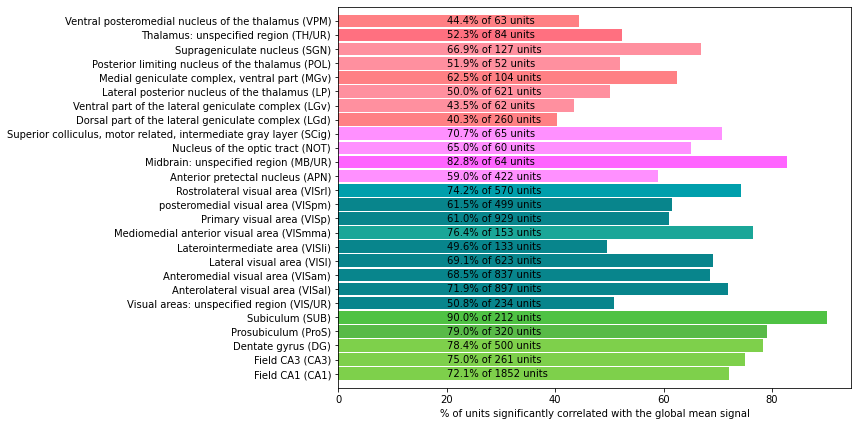

In [12]:
oldxlabels = loccountsorted['ecephys_structure_acronym'].unique()
fulllabels = [name_map[acrnm_map[item]]+' ('+item+')' for item in oldxlabels]
fulllabels[5] = 'Visual areas: unspecified region (VIS/UR)'
fulllabels[15] = 'Midbrain: unspecified region (MB/UR)'
fulllabels[-2] = 'Thalamus: unspecified region (TH/UR)'
labelclrs = [np.array(colormap[acrnm_map[item]])/255 for item in oldxlabels]

plt.figure(figsize=(12,6))
rects = plt.barh(loccountsorted['ecephys_structure_acronym'].values[::2],loccountsorted['percentage'].values[1::2]*100,height=.9,color=labelclrs)
for num, rect in enumerate(rects):
    plt.text(20,rect.get_y()+rect.get_height()/2, str(rect.get_width())[:4]+\
             '% of '+str(loccountsorted['one'].values[2*num:2*num+2].sum())+' units', va = 'center')
    # print(rect.get_y())
plt.yticks(np.arange(0,len(fulllabels)),fulllabels)
plt.xlabel('% of units significantly correlated with the global mean signal')
plt.tight_layout(pad=1)
plt.ylim(-1,len(fulllabels))

Note: The following result involve random permutation. It may be slightly difference from the results shown in the paper

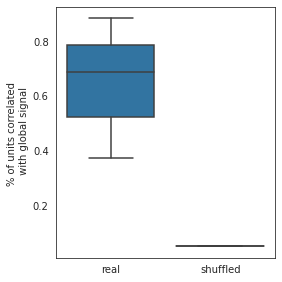

In [13]:
grdf2 = pd.DataFrame(data=gratio2,columns=['gratio'])
grdf2['groups'] = 'real'
grdf3 = pd.DataFrame(data=gratio_c,columns=['gratio'])
grdf3['groups'] = 'shuffled'
grdf2 = grdf2.append(grdf3)
#%%
sns.set_style('white')
fig = plt.figure(figsize = (4,4))
ax = sns.boxplot(x="groups", y="gratio", data=grdf2,fliersize=0,palette=['tab:blue','gray'])
# ax.set_xticklabels(['running','stationary'])
ax.set_xlabel('')
ax.set_ylabel('% of units correlated \n with global signal')
fig.tight_layout(pad=1)

Note: The following result involve random permutation. It may be slightly difference from the results presented in the paper

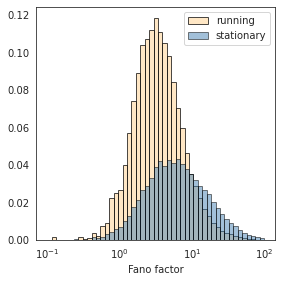

In [14]:
sns.set_style('white')
plt.figure(figsize=(4,4))
plt.hist(ff_all[qtmsk_all==0],bins=10**(np.linspace(-1,2,50)),
         density=True,color='navajowhite',edgecolor='k',alpha=0.7,label='running')
plt.hist(ff_all[qtmsk_all==1],bins=10**(np.linspace(-1,2,50)),
         density=True,color='steelblue',edgecolor='k',alpha=0.5,label='stationary')
plt.gca().set_xscale('log')
# plt.xlim(0.0003,.3)
plt.legend()
plt.xlabel('Fano factor')
plt.tight_layout(pad=1)

Note: The following result involve random permutation. It may be slightly difference from the results presented in the paper

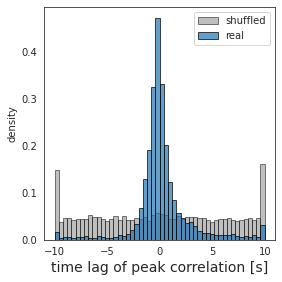

In [15]:
sns.set_style('white')
plt.figure(figsize=(4,4))
plt.hist(pktime_c2,bins=50,density=True,color='gray',edgecolor='k',alpha=0.5,label='shuffled')
plt.hist(pktime,bins=50,density=True,color='tab:blue',edgecolor='k',alpha=0.7,label='real')

plt.ylabel('density')
plt.legend()
plt.xlabel('time lag of peak correlation [s]',fontsize=14)
plt.tight_layout(pad=1)

### Delay Profiles

/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

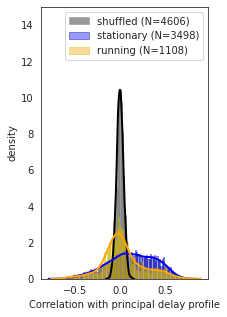

In [16]:
sns.set_style('white')
plt.figure(figsize=(3,5))
sns.distplot(dc_c, hist=True, kde=True, 
             bins=np.linspace(-0.7,0.7,100), color = 'black', 
             hist_kws={'edgecolor':'gray'},
             kde_kws={'linewidth': 2},
             label='shuffled (N='+str(dc_c.size)+')')
sns.distplot(dc[segmsk==1], hist=True, kde=True, 
             bins=np.linspace(-0.7,0.7,100), color = 'b', 
             hist_kws={'edgecolor':'darkblue'},
             kde_kws={'linewidth': 2},
             label='stationary (N='+str((segmsk==1).sum())+')')
sns.distplot(dc[segmsk==0], hist=True, kde=True, 
             bins=np.linspace(-0.7,0.7,100), color = 'orange', 
             hist_kws={'edgecolor':'y'},
             kde_kws={'linewidth': 2},
             label='running (N='+str((segmsk==0).sum())+')')
plt.xlabel('Correlation with principal delay profile')
plt.ylabel('density')
plt.ylim(0,15)
plt.legend()

### Neural Cascade

<ipython-input-17-0524c59247c3>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


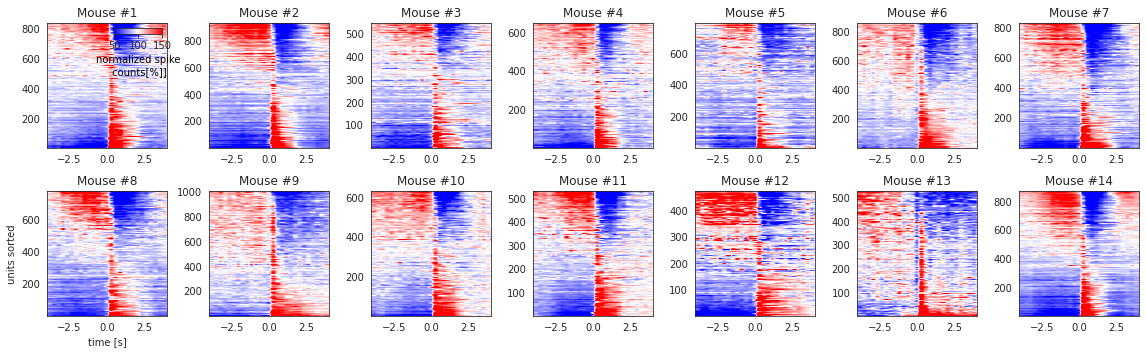

In [17]:
fig,axes = plt.subplots(2,7,figsize =(16,5))
 
for num,segmean in enumerate(segmeanall):
    im=axes[int(num/7),num-int(num/7)*7].imshow(100*segmean[:,sindall[num]].T,vmin = 50, vmax = 150,cmap = 'bwr',aspect='auto', \
                                             extent=[-6,6,1,sindall[num].size])
    axes[int(num/7),num-int(num/7)*7].set_xlim((-4,4))
    axes[int(num/7),num-int(num/7)*7].set_title('Mouse #'+str(num+1))
    if num==7:
        axes[int(num/7),num-int(num/7)*7].set_xlabel('time [s]')
        axes[int(num/7),num-int(num/7)*7].set_ylabel('units sorted')



axins1 = inset_axes(axes[0,0], width="40%",  height="5%",loc='upper right')
cb = fig.colorbar(im,cax=axins1,orientation='horizontal')
# cb.ax.xaxis.set_tick_params(color='w')
# cb.outline.set_edgecolor('w')
# plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w')
cb.set_label('normalized spike\n counts[%]]', color='k')
        
fig.tight_layout(pad=1)

### Measurement around neural cascade 

In [18]:
time_segct = (np.arange(41)-20)/5
time_segpupil = (np.arange(241)-120)/30
time_segrun = (np.arange(321)-160)/40
time_segdp = (np.arange(1001)-500)*10/1249.99839649285
time_segrp = (np.arange(10001)-5000)/1249.99839649285

AmpF = 100
negm = AmpF*negmall.mean(axis=1)
negse = AmpF*negmall.std(axis=1)/np.sqrt(negmall.shape[1])
posm = AmpF*posmall.mean(axis=1)
posse = AmpF*posmall.std(axis=1)/np.sqrt(posmall.shape[1])

pm = AmpF*pmall.mean(axis=1)
pse = AmpF*pmall.std(axis=1)/np.sqrt(pmall.shape[1])

dpm = AmpF*dpmall.mean(axis=1)
dpse = AmpF*dpmall.std(axis=1)/np.sqrt(dpmall.shape[1])

rpm = rpmall.mean(axis=1)
rpse = rpmall.std(axis=1)/np.sqrt(rpmall.shape[1])

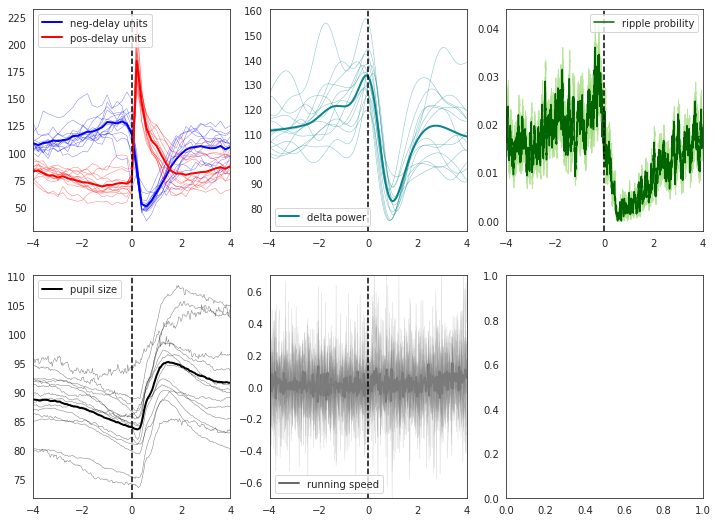

In [19]:
fig,axes = plt.subplots(2,3,figsize =(12,9))

axes[0,0].plot(time_segct,negm,'b',label='neg-delay units',linewidth=2)
axes[0,0].plot(time_segct,negmall*100,'b',alpha=0.5,linewidth=0.5)
# axes[0,0].fill_between(time_segct,negm-negse,negm+negse,alpha =0.5)
axes[0,0].plot(time_segct,posm,'r',label='pos-delay units',linewidth=2)
axes[0,0].plot(time_segct,posmall*100,'r',alpha=0.5,linewidth=.5)
# axes[0,0].fill_between(time_segct,posm-posse,posm+posse,alpha =0.5)
axes[0,0].set_xlim((-4,4))
# axes[0,0].set_ylim((30,300))
axes[0,0].axvline(0,color='k',linestyle='--')
axes[0,0].legend(loc='upper left')

axes[1,0].plot(time_segpupil,pm,'k',label='pupil size',linewidth=2)
axes[1,0].plot(time_segpupil,pmall*100,'k',linewidth=.5,alpha=0.5,)
# axes[1,0].fill_between(time_segpupil,pm-pse,pm+pse,color = 'gray',alpha =0.5)
axes[1,0].set_xlim((-4,4))
axes[1,0].axvline(0,color='k',linestyle='--')
axes[1,0].legend()
      
axes[0,1].plot(time_segdp,dpm,color=np.array(colormap[acrnm_map['VIS']])/255,label='delta power',linewidth=2)
axes[0,1].plot(time_segdp,dpmall*100,color=np.array(colormap[acrnm_map['VIS']])/255,alpha=0.5,linewidth=.5)
# axes[2,0].fill_between(time_segdp,dpm-dpse,dpm+dpse,color = np.array(colormap[acrnm_map['VIS']])/255,alpha =0.5)
axes[0,1].set_xlim((-4,4))
axes[0,1].axvline(0,color='k',linestyle='--')
axes[0,1].legend()

axes[1,1].plot(time_segrun,rmall.mean(axis=1),'dimgray',label='running speed',linewidth=2)
axes[1,1].plot(time_segrun,rmall,'gray',linewidth=.5,alpha=0.3)
axes[1,1].set_xlim((-4,4))
axes[1,1].set_ylim((-.7,.7))
axes[1,1].axvline(0,color='k',linestyle='--')
axes[1,1].legend()

axes[0,2].plot(time_segrp,rpm,color='darkgreen',label='ripple probility')
axes[0,2].fill_between(time_segrp,rpm-rpse,rpm+rpse,color =np.array(colormap[acrnm_map['HPF']])/255,alpha =0.5)
axes[0,2].set_xlim((-4,4))
axes[0,2].axvline(0,color='k',linestyle='--')
axes[0,2].legend()

In [20]:
corr_wps=[]
corr_wrd=[]
for item in session_used:
    tmp = unitall_df.loc[unitall_df['ecephys_session_id']==item,['delay_sec','pscorr','running_spkdiff']]
    corr_wps.append(tmp.corr().iloc[0,1])
    corr_wrd.append(tmp.corr().iloc[0,2])
corr_wps = np.array(corr_wps)
corr_wrd = np.array(corr_wrd)
print([corr_wps.mean(),corr_wps.std()])
print([corr_wrd.mean(),corr_wrd.std()])
corrdlydf = pd.DataFrame(data=corr_wps,columns=['corr'])
corrdlydf['variables'] = 'pupil'
tmp = pd.DataFrame(data=corr_wrd,columns=['corr'])
tmp['variables'] = 'running'
corrdlydf = corrdlydf.append(tmp)

print(stats.ttest_1samp(corr_wps,0))
print(stats.ttest_1samp(corr_wrd,0))

[0.6202932766525455, 0.07589687476780521]
[0.5522448380821382, 0.0821627242025656]
Ttest_1sampResult(statistic=29.46760616479331, pvalue=2.73286899558141e-13)
Ttest_1sampResult(statistic=24.234190134767736, pvalue=3.326569402801908e-12)


In [21]:
sid  = session_used[1]
tmp = unitall_df.loc[unitall_df['ecephys_session_id']==sid,['delay_sec','pscorr','running_spkdiff']]
print(stats.pearsonr(tmp['delay_sec'].values,tmp['pscorr'].values))
print(stats.pearsonr(tmp['delay_sec'].values,tmp['running_spkdiff'].values))

(0.5687683543501145, 8.075407121465009e-81)
(0.5393975071325493, 2.5070713439011598e-71)


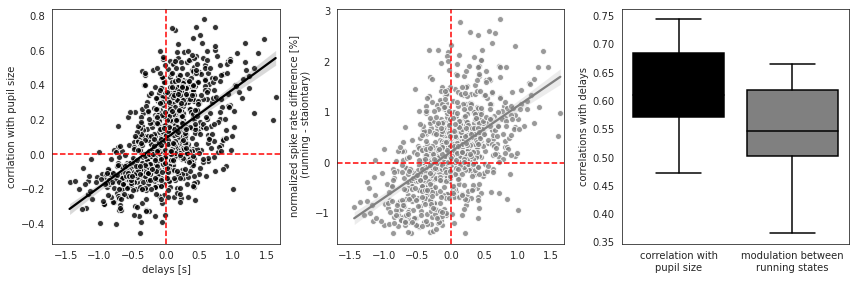

In [22]:
fig,axes = plt.subplots(1,3,figsize =(12,4))
sns.regplot(x="delay_sec", y="pscorr", color='k',data=unitall_df[unitall_df['ecephys_session_id']==sid],ax=axes[0],\
            line_kws = {'color':'k'}, scatter_kws={'edgecolor':'w'})
axes[0].axhline(0,color='r',linestyle='--')
axes[0].axvline(0,color='r',linestyle='--')
axes[0].set_xlabel('delays [s]')
axes[0].set_ylabel('corrlation with pupil size')
axes[0].set_xlim([-1.7,1.7])
sns.regplot(x="delay_sec", y="running_spkdiff", color='gray',data=unitall_df[unitall_df['ecephys_session_id']==sid],ax=axes[1],
            line_kws = {'color':'gray'}, scatter_kws={'edgecolor':'w'})
axes[1].axhline(0,color='r',linestyle='--')
axes[1].axvline(0,color='r',linestyle='--')
axes[1].set_xlabel('')
axes[1].set_ylabel('normalized spike rate difference [%]\n (running - staiontary)')
axes[1].set_xlim([-1.7,1.7])
sns.boxplot(x="variables", y="corr", data=corrdlydf,fliersize=0,palette=['k','gray'],ax=axes[2])
axes[2].set_xticklabels(['correlation with\npupil size','modulation between\nrunning states'])
axes[2].set_xlabel('')
axes[2].set_ylabel('correlations with delays')

fig.tight_layout(pad=1)

### Spatial Organization

In [23]:
structure_set_ids = structure_tree.get_structure_sets()
structure_sets = pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

summary_structures = structure_tree.get_structures_by_set_id([167587189])
summary_structures = pd.DataFrame(summary_structures)

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

In [24]:
loc_df = unitall_df[['location','ecephys_session_id']].groupby(['location'],as_index=False)\
                                                      .count()\
                                                      .rename(columns={"ecephys_session_id": "unit_count"})
fullnames = [name_map[acrnm_map[item]] for item in loc_df.location]
loc_df['fullname'] = fullnames

pivoted = unitall_df.pivot_table(values ='delays', index='location', columns='delay_groups', fill_value = 0, aggfunc='count')
flatten = pd.DataFrame(pivoted.to_records())
loc_df = pd.merge(loc_df, flatten, on='location').rename(columns={'-1': 'group_neg_count', 
                                                                  '0': 'group_zero_count', 
                                                                  '1': 'group_pos_count'})
loc_df['percentage_neg'] = loc_df.group_neg_count / loc_df.unit_count
loc_df['percentage_zero'] = loc_df.group_zero_count / loc_df.unit_count
loc_df['percentage_pos'] = loc_df.group_pos_count / loc_df.unit_count

loc_df = loc_df.set_index('location')

In [25]:
# Region: 'TH', 'MB', 'Isocortex', 'HPF'
ancestorgrpids = [549,313,315,1089]
reg100 = loc_df.loc[loc_df.unit_count > 100].index.unique()

structids  = [acrnm_map[item] for item in reg100]
ancestor_ids = structure_tree.ancestor_ids(structids)
ancestorids = []
for item in ancestor_ids:
    ancestorids.append(np.array(item)[np.in1d(item,ancestorgrpids)].squeeze())
ancestorids = np.array(ancestorids)
ancestoracrnm = [id_map[item] for item in ancestorids]

reg100sort = reg100[np.argsort(ancestoracrnm)]
ancestoracrnm.sort()
reg100sort.values[0],reg100sort.values[3] = reg100sort.values[3],reg100sort.values[0]
ancestoracrnm[0], ancestoracrnm[3] = ancestoracrnm[3], ancestoracrnm[0]
reg100acst_map = pd.DataFrame(data=ancestoracrnm, index=reg100sort, columns=['ancestors'])

locperct100 = loc_df.loc[reg100sort, ['percentage_neg','percentage_zero','percentage_pos']]
loccount100 = loc_df.loc[reg100sort, ['group_neg_count','group_zero_count',	'group_pos_count']]

In [26]:
dlygrp_cnt = np.zeros((2,2))
# negative neuron total count
dlygrp_cnt[0,0] = loccount100.sum().values[0]
# positive neuron total count
dlygrp_cnt[0,1] = loccount100.sum().values[-1]
dlygrp_cnt = dlygrp_cnt.squeeze()
reg100pv = []
reg100pv2 = []
reg100pv3 = []
for reg in reg100sort:
    dlygrp_cnt[1,0] = loccount100.loc[reg, 'group_neg_count'] 
    dlygrp_cnt[1,1] = loccount100.loc[reg, 'group_pos_count'] 
    ratio = dlygrp_cnt[0,0]/dlygrp_cnt[0].sum()
    
    dlygrp_cnt2 = dlygrp_cnt.copy()
    dlygrp_cnt2[0,:] = dlygrp_cnt[0,:] - dlygrp_cnt[1,:]
    
    reg100pv.append(stats.fisher_exact(dlygrp_cnt)[-1])
    reg100pv2.append(stats.fisher_exact(dlygrp_cnt2)[-1])
    reg100pv3.append(proportions_ztest(dlygrp_cnt[1,0],dlygrp_cnt[1].sum(),ratio))
    
reg100pv_corrected = np.array(reg100pv)*len(reg100pv)
reg100pv2_corrected = np.array(reg100pv2)*len(reg100pv2)
reg100pv3_corrected = np.array(reg100pv3)*len(reg100pv3)

/home/yifan/anaconda3/envs/allensdk2/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


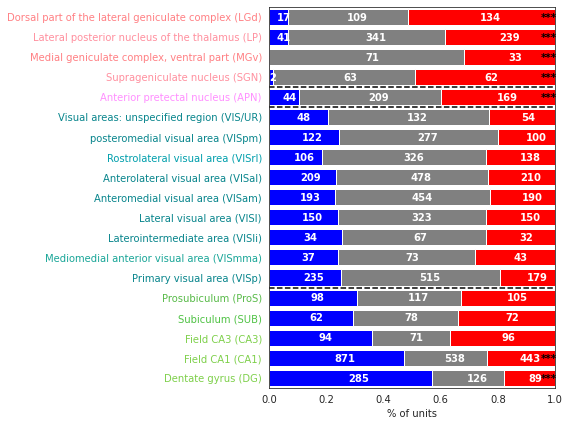

In [27]:
sns.set_style('white')
fulllabels = [name_map[acrnm_map[item]]+' ('+item+')' for item in reg100sort]
fulllabels[13] = 'Visual areas: unspecified region (VIS/UR)'
labelclrs = [np.array(colormap[acrnm_map[item]])/255 for item in reg100sort]

plt.figure(figsize=(8,6))
rects0= plt.barh(locperct100.index, locperct100.iloc[:,0],height=.8,color='b')
rects1 = plt.barh(locperct100.index, locperct100.iloc[:,1],left = locperct100.iloc[:,0], height=.8,color='gray')
rects2 = plt.barh(locperct100.index, locperct100.iloc[:,2],left = locperct100.iloc[:,:2].sum(axis=1), height=.8,color='r')
# plt.barh(loccountsorted['ecephys_structure_acronym'].values[::2],loccountsorted['percentage'].values[::2],\
#         left=loccountsorted['percentage'].values[1::2],height=.7)
for num, rect in enumerate(rects0):
    if rect.get_width()!=0:
        plt.text(rect.get_width()/2-.006,rect.get_y()+rect.get_height()/2-0.02, str(loccount100.iloc[num,0]), va = 'center',\
                 color='w',fontweight='bold')
for num, rect in enumerate(rects1):
    if rect.get_width()!=0:
        plt.text(rect.get_width()/2-.004+locperct100.iloc[num,0],rect.get_y()+rect.get_height()/2-0.02, str(loccount100.iloc[num,1]), va = 'center',\
                 color='w',fontweight='bold')
for num, rect in enumerate(rects2):
    if rect.get_width()!=0:
        plt.text(rect.get_width()/2-.004+locperct100.iloc[num,:2].sum(),rect.get_y()+rect.get_height()/2-0.02, str(loccount100.iloc[num,2]), \
                 va = 'center',color='w',fontweight='bold')
    if reg100pv_corrected[num]<0.001:
        plt.text(0.95,rect.get_y()+rect.get_height()/2-0.02, '***', \
                 va = 'center',color='k',fontweight='bold')
        
    # print(rect.get_y())
plt.yticks(np.arange(0,len(fulllabels)),fulllabels)
for ytick, color in zip(plt.gca().get_yticklabels(), labelclrs):
    ytick.set_color(color)
plt.xlabel('% of units')
plt.xlim((0,1))
plt.tight_layout(pad=1)
plt.ylim(-.5,len(fulllabels)-0.5)
plt.axhline(4.5,color='k',linestyle='--')
plt.axhline(13.5,color='k',linestyle='--')
plt.axhline(14.5,color='k',linestyle='--')


<ipython-input-28-0e91fa24e7b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit100['ancestors'] = reg100acst_map.loc[unit100.location,'ancestors'].values.squeeze()


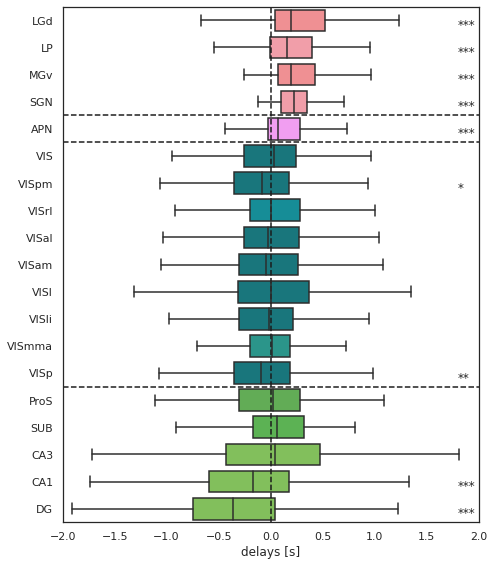

In [28]:
unit100 = unitall_df[unitall_df['location'].isin(reg100sort)]
unit100['ancestors'] = reg100acst_map.loc[unit100.location,'ancestors'].values.squeeze()
#%%
unit100gbreg = unit100[['location','delay_sec']].groupby('location')
unit100tscore = unit100gbreg.apply(lambda x: stats.ttest_1samp(x,0))
unit100tscore_sorted = unit100tscore.loc[reg100sort]

#%%
test = unit100.sort_values(by=['ancestors','delay_tscore'])
sns.set(style="white")

hpfclr = np.array(colormap[acrnm_map['HPF']].copy())/255
isoclr = np.array(colormap[acrnm_map['Isocortex']].copy())/255
mbclr = np.array(colormap[acrnm_map['MB']].copy())/255
thclr = np.array(colormap[acrnm_map['TH']].copy())/255

my_pal = {}
for reg in reg100sort:
    my_pal[reg] = np.array(colormap[acrnm_map[reg100acst_map.loc[reg].squeeze()]].copy())/255

plt.figure(figsize=(7,8))
# axis = sns.violinplot(y="location", x="delay_sec",order = reg100sort,data=test, orient='h', scale='width',bw=0.15,cut=0, palette=labelclrs)
axis = sns.boxplot(y="location", x="delay_sec",order = reg100sort,data=test, orient='h', palette=labelclrs, fliersize=0)
axis.axvline(0,linestyle='--',color='k')
axis.axhline(4.5,linestyle='--',color='k')
axis.axhline(13.5,linestyle='--',color='k')
axis.axhline(14.5,linestyle='--',color='k')
axis.set_xlim(-2,2)
# axis = sns.boxplot(x="location", y="delay_sec",order = reg100sort,data=test, orient='v', palette=my_pal)
# plt.xticks(rotation=45)
# plt.yticks(np.arange(0,len(fulllabels)),fulllabels)
plt.xlabel('delays [s]')
plt.ylabel('')
plt.gca().invert_yaxis()
plt.tight_layout(pad=1)

# plt.xticks(rotation=45)
for num,item in enumerate(unit100tscore_sorted):
    if item[1]*unit100tscore_sorted.size<0.001:
        plt.text(1.8,num-0.3,'***')
    else:
        if item[1]*unit100tscore_sorted.size<0.01:
            plt.text(1.8,num-0.3,'**')
        else:
            if item[1]*unit100tscore_sorted.size<0.05:
                  plt.text(1.8,num-0.3,'*')

In [29]:
mcc = MouseConnectivityCache(resolution = 10, 
                             manifest_file = settings.connectivity.manifest_path)
annot2, annot_info2 = mcc.get_annotation_volume()

In [30]:
unitall_df = unitall_df.drop(index = unitall_df[unitall_df[['lrc','dvc','apc']].isna().any(axis=1)].index)
coords=(unitall_df[['lrc','dvc','apc']]/10).astype(int)
structids = annot2[coords.apc,coords.dvc,coords.lrc]

loc2 = []
for item in structids:
    loc2.append(id_map[item])
loc3 = [item[-1] for item in loc2]

unitall_df['location2'] = np.array(loc3)


unitvis = unitall_df[unitall_df['location'].str.match('VIS').values]
unitvis = unitvis[unitvis['location2'].str.match('p').values!=1]
unitvis = unitvis[unitvis['location2'].str.match('1').values!=1]
unitvis.loc[unitvis['location2']=='a','location2']='6'
unitvis.loc[unitvis['location2']=='b','location2']='6'
unitvis = unitvis.sort_values(by=['location2'])

unitvisgb = unitvis[['location2','delay_sec']].groupby('location2')
unitlayers_mean = unitvisgb.mean()
unitlayers_sem = unitvisgb.sem()
unitlayers_cnt = unitvisgb.count()
unitlayers_t = unitvisgb.mean()/unitvisgb.sem()

#
unitvisgb.apply(lambda x: stats.ttest_1samp(x,0))
#%%
viscount = unitvis.pivot_table(values = 'delays',index='location2',columns='delay_groups', fill_value = 0, aggfunc='count')

viscount2 = viscount.T.sum()
tmp = (viscount.values.T/viscount2.values.T).T
visperct = pd.DataFrame(data=tmp, index =viscount.index, columns = viscount.columns)

#%%
vis_cnt = np.zeros((2,2))
vis_cnt[0,0] = viscount.sum().values[0]
vis_cnt[0,1] = viscount.sum().values[-1]
vis_cnt = vis_cnt.squeeze()
ratio2 = vis_cnt[0,0]/vis_cnt[0].sum()

vispv = []
vispv2 = []
vispv3 = []
for reg in viscount.index:
    vis_cnt[1,0] = viscount.loc[reg,-1] 
    vis_cnt[1,1] = viscount.loc[reg,1] 
    
    
    vis_cnt2 = vis_cnt.copy()
    vis_cnt2[0,:] = vis_cnt[0,:]-vis_cnt[1,:]
    
#     print(reg)
#     print(stats.fisher_exact(vis_cnt))
#     print(stats.fisher_exact(vis_cnt2))
#     print(proportions_ztest(vis_cnt[1,0],vis_cnt[1].sum(),ratio2))
    
    vispv.append(stats.fisher_exact(vis_cnt)[-1])
    vispv2.append(stats.fisher_exact(vis_cnt2)[-1])
    vispv3.append(proportions_ztest(vis_cnt[1,0],vis_cnt[1].sum(),ratio2))
    
vispv_corrected = np.array(vispv)*len(vispv)
vispv2_corrected = np.array(vispv2)*len(vispv2)
vispv3_corrected = np.array(vispv3)*len(vispv3)


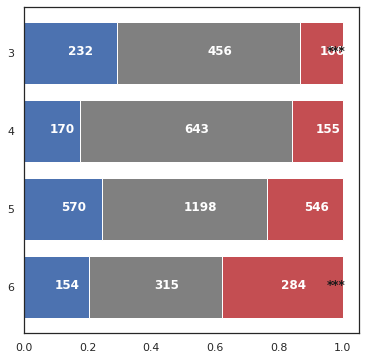

In [31]:
sns.set_style('white')

plt.figure(figsize=(6,6))
rects0= plt.barh(visperct.index, visperct.iloc[:,0],height=.8,color='b')
rects1 = plt.barh(visperct.index, visperct.iloc[:,1],left = visperct.iloc[:,0], height=.8,color='gray')
rects2 = plt.barh(visperct.index, visperct.iloc[:,2],left = visperct.iloc[:,:2].sum(axis=1), height=.8,color='r')
# plt.barh(loccountsorted['ecephys_structure_acronym'].values[::2],loccountsorted['percentage'].values[::2],\
#         left=loccountsorted['percentage'].values[1::2],height=.7)
for num, rect in enumerate(rects0):
    if rect.get_width()!=0:
        plt.text(rect.get_width()/2-.006,rect.get_y()+rect.get_height()/2-0.02, str(viscount.iloc[num,0]), va = 'center',\
                 color='w',fontweight='bold')
for num, rect in enumerate(rects1):
    if rect.get_width()!=0:
        plt.text(rect.get_width()/2-.004+visperct.iloc[num,0],rect.get_y()+rect.get_height()/2-0.02, str(viscount.iloc[num,1]), va = 'center',\
                 color='w',fontweight='bold')
for num, rect in enumerate(rects2):
    if rect.get_width()!=0:
        plt.text(rect.get_width()/2-.004+visperct.iloc[num,:2].sum(),rect.get_y()+rect.get_height()/2-0.02, str(viscount.iloc[num,2]), \
                 va = 'center',color='w',fontweight='bold')
    if vispv_corrected[num]<0.001:
        plt.text(0.95,rect.get_y()+rect.get_height()/2-0.02, '***', \
                  va = 'center',color='k',fontweight='bold')
        
    # print(rect.get_y())
plt.gca().invert_yaxis()

<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels([' ',' ',' '])
<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels([' ',' ',' '])
<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels([' ',' ',' '])
<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels([' ',' ',' '])
<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels([' ',' ',' '])
<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[num].set_xticklabels([' ',' ',' '])
<ipython-input-32-aa43f9ab5463>:28: UserWarning: FixedFormatter should only be use

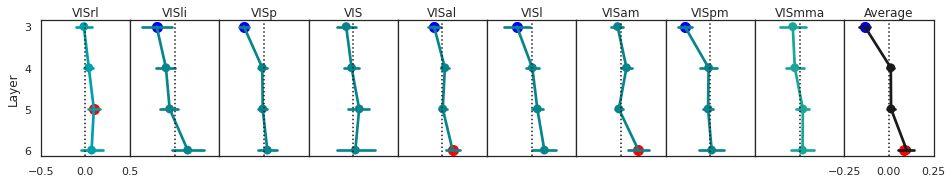

In [32]:
unitvisgb2 = unitvis[['location','location2','delay_sec']].groupby(['location','location2'])
unitlayers2_mean = unitvisgb2.mean()
unitlayers2_sem = unitvisgb2.sem()
unitlayers2_cnt = unitvisgb2.count()
unitlayers2_t = unitvisgb2.mean()/unitvisgb2.sem()

unitlayertscore = unitvisgb2.apply(lambda x: stats.ttest_1samp(x,0))
# unitlayertscore_sorted = unit100tscore.loc[reg100sort]

visregs = unitvis.location.unique()
sns.set(style="white")
fig, axs = plt.subplots(1, visregs.size+1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
fig.set_size_inches(16,2.5)
for num, visreg in enumerate(visregs):
    sns.pointplot(y="location2", x="delay_sec", orient='h', data=unitvis[unitvis['location']==visreg],ci=95,ax=axs[num],\
                  color=np.array(colormap[acrnm_map[visreg]])/255)
    axs[num].set_xlim([-0.5, 0.5])
    axs[num].axvline(0,linestyle=':',color='k')
    axs[num].set_xlabel(visreg)
    axs[num].xaxis.set_label_position('top')

    
    if num==0:
        axs[num].set_ylabel('Layer')
        axs[num].set_yticklabels(["L2/3","L4","L5","L6"])
         
    else:
        axs[num].set_xticklabels([' ',' ',' '])
        axs[num].set_ylabel('')

sns.pointplot(y="location2", x="delay_sec", orient='h', data=unitvis,ci=95,ax=axs[-1],color='k')
axs[-1].set_xlim([-0.25, 0.25])
axs[-1].axvline(0,linestyle=':',color='k')
axs[-1].set_xlabel('Average')
axs[-1].set_ylabel('')
axs[-1].xaxis.set_label_position('top')

for num, visreg in enumerate(visregs):
    for num2 in range(4):
        if unitlayertscore[visreg].values[num2][1]<0.05:
            if unitlayertscore[visreg].values[num2][0]<0:
                axs[num].scatter(unitlayers2_mean.loc[visreg].values[num2],num2,s=100,color='blue')
            else:
                axs[num].scatter(unitlayers2_mean.loc[visreg].values[num2],num2,s=100, color='red')
axs[-1].scatter(unitlayers2_mean.values[0::4].mean(),0,s=100,color='blue')
axs[-1].scatter(unitlayers2_mean.values[3::4].mean(),3,s=100,color='red')


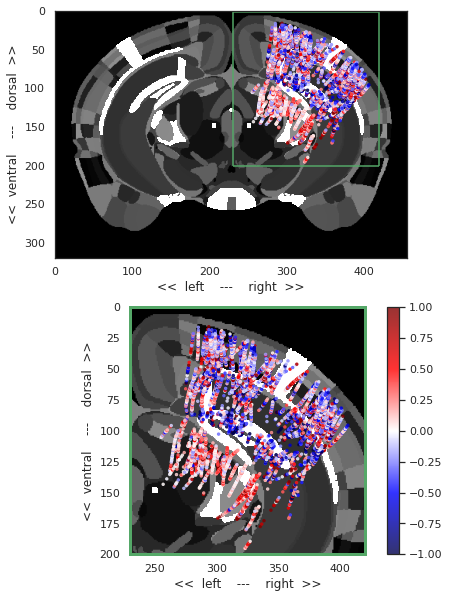

In [33]:
chngb = unitall_df.groupby('ecephys_channel_id')
chnall = chngb.mean()
chnall['location'] = chngb.first()['location']
chnall['location2'] = chngb.first()['location2']

markermsk = (chnall['location']=='CA1')|(chnall['location']=='DG')

sns.set(style="white")
fig, axes = plt.subplots(2, 1,figsize= (8,10))

axes[0].imshow(annot[325,:,:], cmap='gray', aspect='equal',  vmin=0, vmax=2000)
# tmp = chnall[markermsk==False]
# axes[0].scatter((tmp['lrc']/25), (tmp['dvc']/25), c=tmp['delay_sec'], s=6, cmap='seismic',alpha=0.8, \
#                 marker= 'o', norm = mcolors.Normalize(vmin=-2, vmax=2))
# tmp = chnall[markermsk]
# axes[0].scatter((tmp['lrc']/25), (tmp['dvc']/25), c=tmp['delay_sec'], s=6, cmap='seismic',alpha=0.8, \
#                 marker = 'v',norm = mcolors.Normalize(vmin=-2, vmax=2))
axes[0].scatter((chnall['lrc']/25), (chnall['dvc']/25), c=chnall['delay_sec'], s=6, cmap='seismic',alpha=0.8, 
                norm = mcolors.Normalize(vmin=-1, vmax=1))
# plt.scatter((chnall['lrc']/25), (chnall['dvc']/25), c=chnall['loc'].str.match('VIS'), s=6, cmap='jet',alpha=0.8, \
    # norm = mcolors.Normalize(vmin=-2, vmax=2))
axes[0].set_ylabel('<<  ventral    ---    dorsal  >>')
axes[0].set_xlabel('<<  left    ---    right  >>')
axes[0].vlines(x=[230,420],ymin=0,ymax=200,color='g')
axes[0].hlines(y=[1,200],xmin=230,xmax=420,color='g')

axes[1].imshow(annot[325,:,:], cmap='gray', aspect='equal',  vmin=0, vmax=2000)
im=axes[1].scatter((chnall['lrc']/25), (chnall['dvc']/25), c=chnall['delay_sec'], s=6, cmap='seismic',alpha=0.8, 
                norm = mcolors.Normalize(vmin=-1, vmax=1))
# plt.scatter((chnall['lrc']/25), (chnall['dvc']/25), c=chnall['loc'].str.match('VIS'), s=6, cmap='jet',alpha=0.8, \
    # norm = mcolors.Normalize(vmin=-2, vmax=2))
axes[1].set_ylabel('<<  ventral    ---    dorsal  >>')
axes[1].set_xlabel('<<  left    ---    right  >>')
axes[1].set_xlim((230,420))
axes[1].set_ylim((200,0))
axes[1].spines['right'].set_color('g')
axes[1].spines['left'].set_color('g')
axes[1].spines['top'].set_color('g')
axes[1].spines['bottom'].set_linewidth(3)
axes[1].spines['right'].set_linewidth(3)
axes[1].spines['left'].set_linewidth(3)
axes[1].spines['top'].set_linewidth(3)
axes[1].spines['bottom'].set_color('g')

plt.colorbar(im)

### Pupil Tracking

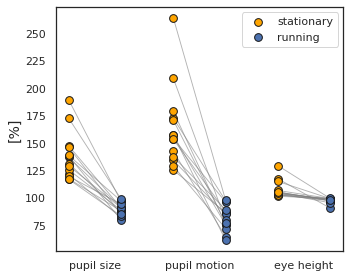

In [34]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot()
x_centers = [2, 6, 10] 
x_offset = 1

def update_ticks(x, pos):
    if x == x_centers[2]:
        return 'eye height'
    elif x == x_centers[0]:
        return 'pupil size'
    elif x == x_centers[1]:
        return 'pupil motion'
    else:
        return ''
sns.set(style="white")
for data, x_center in zip([ppsize3, ppdist3, eyeheight3], x_centers):
    stpts = ax.scatter(np.ones_like(data[:,0]) * x_center - x_offset, data[:,0] * 100, 
                    edgecolors='k', s=60, zorder=10, color='orange')
    runpts = ax.scatter(np.ones_like(data[:,1]) * x_center + x_offset, data[:,1] * 100, 
                    edgecolors='k', s=60, zorder=10, color='b')
    for num in range(session_used.shape[0]):
        c = 'r' if ppsize2[num,0] < ppsize2[num,1] else 'b'
        ax.plot([x_center-x_offset, x_center+x_offset], [data[num,0] * 100, data[num,1] * 100], 
                 c='grey', alpha=0.6, linewidth=0.9)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
ax.legend([stpts, runpts], ['stationary', 'running'])
ax.set_ylabel('[%]',fontsize=14)
fig.tight_layout(pad=1)

### PCA

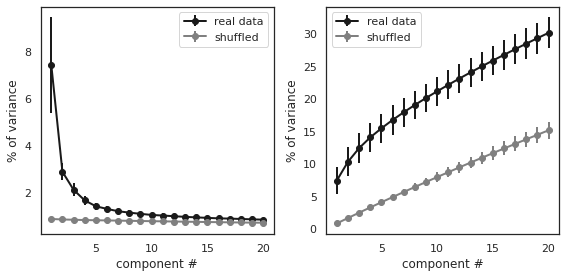

In [35]:
topn = 20

svarcum_all = np.cumsum(svarp_all, axis=0)
svarcum_all_pm = np.cumsum(svarp_all_pm, axis=0)

fig,axes = plt.subplots(1,2,figsize =(8,4))
axes[0].errorbar(np.arange(topn)+1,svarp_all.mean(axis=1)*100,yerr = svarp_all[:topn,].std(axis=1)*100,\
            linewidth=2,marker='o', color='k', label='real data')
axes[0].errorbar(np.arange(topn)+1,svarp_all_pm[:topn,].mean(axis=1)*100,yerr = svarp_all_pm[:topn,].std(axis=1)*100,\
            linewidth=2,marker='o', color='gray', label='shuffled')
axes[0].legend()
axes[0].set_xlabel('component #')
axes[0].set_ylabel('% of variance')

axes[1].errorbar(np.arange(topn)+1,svarcum_all.mean(axis=1)*100,yerr = svarcum_all[:topn,].std(axis=1)*100,\
            linewidth=2,marker='o', color='k', label='real data')
axes[1].errorbar(np.arange(topn)+1,svarcum_all_pm[:topn,].mean(axis=1)*100,yerr = svarcum_all_pm[:topn,].std(axis=1)*100,\
            linewidth=2,marker='o', color='gray', label='shuffled')
axes[1].legend()
axes[1].set_xlabel('component #')
axes[1].set_ylabel('% of variance')
fig.tight_layout(pad=1)

### Stimulus Response

In [36]:
corr_res['cond'] = corr_res['contrast'].astype(str)+' '+corr_res['orientation'].astype(str)
condord= corr_res.cond.unique()[[6,4,5,7,2,0,1,3]]

test = corr_res[(corr_res['index']=='dgr_rsp2')]
test2= corr_res[(corr_res['index']=='dgr_rsp3')]
testgb = test[['dgr_bldiff','cond']].groupby('cond')
test2gb = test2[['dgr_bldiff','cond']].groupby('cond')

print(testgb.apply(lambda x: stats.ttest_1samp(x,0)))
print(test2gb.apply(lambda x: stats.ttest_1samp(x,0)))

print(testgb.mean().mean())
print(testgb.mean().std())
print(stats.ttest_1samp(testgb.mean(),0))

print(test2gb.mean().mean())
print(test2gb.mean().std())
print(stats.ttest_1samp(test2gb.mean(),0))

print(stats.ttest_1samp(testgb.mean()-test2gb.mean(),0))

cond
0.1 0.0        ([-11.973663389984626], [2.14555648189471e-08])
0.1 135.0     ([-13.696327892082673], [4.215194897492347e-09])
0.1 45.0       ([-9.975755938186637], [1.850623589629255e-07])
0.1 90.0     ([-14.708909430533643], [1.7576634446113701e-09])
0.8 0.0       ([-13.148163792846614], [6.933018569317049e-09])
0.8 135.0     ([-24.402461310224457], [3.045891573137069e-12])
0.8 45.0       ([-13.529364453136882], [4.89582657587135e-09])
0.8 90.0      ([-13.816113833418372], [3.789710658231451e-09])
dtype: object
cond
0.1 0.0       ([-5.276731110299217], [0.00014976901671791466])
0.1 135.0    ([-12.672231932677978], [1.0839421156029192e-08])
0.1 45.0      ([-7.798698591459152], [2.9525138939200675e-06])
0.1 90.0      ([-7.948585048670609], [2.3995525936475225e-06])
0.8 0.0         ([-5.320493776686062], [0.000138870779046917])
0.8 135.0      ([-7.63933501152924], [3.6917966837247967e-06])
0.8 45.0       ([-4.673656538001411], [0.0004354647113832008])
0.8 90.0      ([-4.745408276071

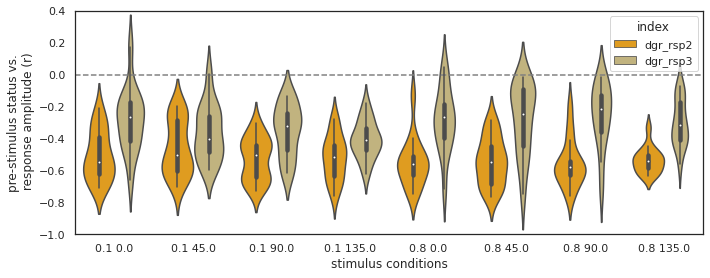

In [37]:
plt.figure(figsize=(10,4))
sns.violinplot(x='cond',y='dgr_bldiff',hue='index',\
               data = corr_res[(corr_res['index']=='dgr_rsp2')|(corr_res['index']=='dgr_rsp3')],\
               order = condord,bw=0.5,inner='box',palette={"dgr_rsp2":"orange","dgr_rsp3": "y"})
plt.xlabel('stimulus conditions')
plt.ylabel('pre-stimulus status vs.\n response amplitude (r)')
plt.ylim(-1,0.4)
plt.xlim(-.5,7.5)
plt.gca().hlines(y=0,xmin=-.5,xmax=7.5,linestyle='--',color='gray')
plt.gcf().tight_layout(pad=1)

In [38]:
dgrexp=dgrdf[(dgrdf['contrast']==0.8)&(dgrdf['orientation']==90)]
dgrtc_exp = dgrtc_all[:,(dgrdf['contrast']==0.8)&(dgrdf['orientation']==90)]*20

dgr_l_mean = dgrtc_exp[:,dgrexp['dgr_topr_blcg']==0].mean(axis=1)
dgr_l_se = dgrtc_exp[:,dgrexp['dgr_topr_blcg']==0].std(axis=1)/np.sqrt((dgrexp['dgr_topr_blcg']==0).sum())
dgr_m_mean = dgrtc_exp[:,dgrexp['dgr_topr_blcg']==1].mean(axis=1)
dgr_m_se = dgrtc_exp[:,dgrexp['dgr_topr_blcg']==1].std(axis=1)/np.sqrt((dgrexp['dgr_topr_blcg']==1).sum())
dgr_h_mean = dgrtc_exp[:,dgrexp['dgr_topr_blcg']==2].mean(axis=1)
dgr_h_se = dgrtc_exp[:,dgrexp['dgr_topr_blcg']==2].std(axis=1)/np.sqrt((dgrexp['dgr_topr_blcg']==2).sum())

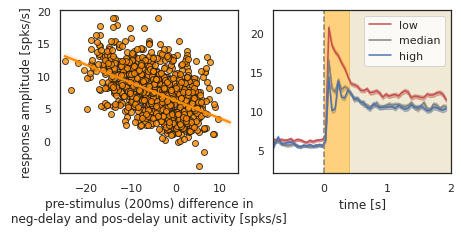

In [39]:
fig,(ax3,ax4) = plt.subplots(1,2,figsize=(7,3))
sns.regplot(data=dgrexp*20,x='dgr_bldiff',y='dgr_rsp2',color='darkorange',ax=ax3,scatter_kws={'edgecolor':'k'})
ax3.set_ylabel('response amplitude [spks/s]')
ax3.set_xlabel('pre-stimulus (200ms) difference in\n neg-delay and pos-delay unit activity [spks/s] ')
ax3.set_xlim(-26,14)

ax4.plot(time_dgr,dgr_l_mean,color='r',label='low')
ax4.fill_between(time_dgr,dgr_l_mean-dgr_l_se,dgr_l_mean+dgr_l_se,color='r',alpha=0.5)
ax4.plot(time_dgr,dgr_m_mean,color='gray',label='median')
ax4.fill_between(time_dgr,dgr_m_mean-dgr_m_se,dgr_m_mean+dgr_m_se,color='gray',alpha=0.5)
ax4.plot(time_dgr,dgr_h_mean,color='b',label='high')
ax4.fill_between(time_dgr,dgr_h_mean-dgr_h_se,dgr_h_mean+dgr_h_se,color='b',alpha=0.5)
ax4.fill_between(np.linspace(0,0.4,100),0,30,color='orange',alpha=0.5)
ax4.fill_between(np.linspace(0.4,2,400),0,30,color='y',alpha=0.3)
ax4.legend()
ax4.set_xlabel('time [s]')
# ax4.set_ylabel('response')
ax4.set_xlim(-0.8,2)
ax4.set_ylim(2,23)
ax4.axvline(0,color='gray',linestyle='--')

### Running / Stationary Transition

In [40]:
spksegtime = (np.arange(401)-200)/5
runsegtime = (np.arange(3201)-1600)/40

nsegsm = nseg_sall.mean(axis=1)
nsegsse = nseg_sall.std(axis=1)/np.sqrt(nseg_sall.shape[1])
nsegem = nseg_eall.mean(axis=1)
nsegese = nseg_eall.std(axis=1)/np.sqrt(nseg_eall.shape[1])

psegsm = pseg_sall.mean(axis=1)
psegsse = pseg_sall.std(axis=1)/np.sqrt(pseg_sall.shape[1])
psegem = pseg_eall.mean(axis=1)
psegese = pseg_eall.std(axis=1)/np.sqrt(pseg_eall.shape[1])

rsegsm = rseg_sall.mean(axis=1)
rsegsse = rseg_sall.std(axis=1)/np.sqrt(rseg_sall.shape[1])
rsegem = rseg_eall.mean(axis=1)
rsegese = rseg_eall.std(axis=1)/np.sqrt(rseg_eall.shape[1])

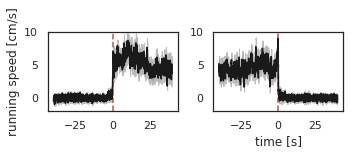

In [41]:
fig,axes = plt.subplots(1,2,figsize =(5,2))

axes[0].plot(runsegtime,rsegsm,'k')
axes[0].fill_between(runsegtime,rsegsm-rsegsse,rsegsm+rsegsse,color='gray',alpha =0.5)
axes[0].vlines(0,ymin=-2,ymax=10,linestyles='dashed',color='r')
axes[0].set_ylim(-2,10)

axes[1].plot(runsegtime,rsegem,'k')
axes[1].fill_between(runsegtime,rsegem-rsegese,rsegem+rsegese,color='gray',alpha =0.5)
axes[1].vlines(0,ymin=-2,ymax=10,linestyles='dashed',color='r')
axes[1].set_ylim(-2,10)
axes[1].set_xlabel('time [s]')
axes[0].set_ylabel('running speed [cm/s]')

fig.tight_layout(pad=1)

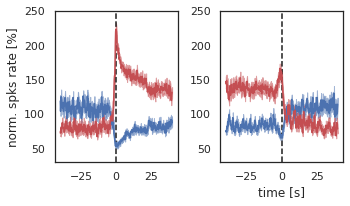

In [42]:
fig,axes = plt.subplots(1,2,figsize =(5,3))

axes[0].plot(spksegtime,nsegsm,'b')
axes[0].fill_between(spksegtime,nsegsm-nsegsse,nsegsm+nsegsse,color='b',alpha =0.5)
axes[0].plot(spksegtime,psegsm,'r')
axes[0].fill_between(spksegtime,psegsm-psegsse,psegsm+psegsse,color='r',alpha =0.5)
axes[0].vlines(0,ymin=30,ymax=250,linestyles='dashed',color='k')
axes[0].set_ylim(30,250)

axes[1].plot(spksegtime,nsegem,'b')
axes[1].fill_between(spksegtime,nsegem-nsegese,nsegem+nsegese,color='b',alpha =0.5)
axes[1].plot(spksegtime,psegem,'r')
axes[1].fill_between(spksegtime,psegem-psegese,psegem+psegese,color='r',alpha =0.5)
axes[1].vlines(0,ymin=30,ymax=250,linestyles='dashed',color='k')
axes[1].set_ylim(30,250)

axes[1].set_xlabel('time [s]')
axes[0].set_ylabel('norm. spks rate [%]')

fig.tight_layout(pad=1)